# Polarization

**Prerequisite: Basic Introduction**

In this notebook parameterization of the polarization primitives and few methods derived from the primitives are presented. In particular, setting up of

* General parameters
* Current/voltage range
* Current/voltage limits
* Online display
* Tolerance limits

is explained in detail.

**Test object:** Polarization measurements are carried out for a 200 F, 2.7 V supercapacitor. 

In [1]:
from zahner_potentiostat.scpi_control.searcher import SCPIDeviceSearcher
from zahner_potentiostat.scpi_control.serial_interface import SerialCommandInterface, SerialDataInterface
from zahner_potentiostat.scpi_control.control import *
from zahner_potentiostat.scpi_control.datahandler import DataManager
from zahner_potentiostat.scpi_control.datareceiver import TrackTypes
from zahner_potentiostat.display.onlinedisplay import OnlineDisplay

from jupyter_utils import executionInNotebook
if __name__ == '__main__':
    deviceSearcher = SCPIDeviceSearcher()
    deviceSearcher.searchZahnerDevices()
    commandSerial, dataSerial = deviceSearcher.selectDevice()

COM14:
ZAHNER-ELEKTRIK,PP242,35000,1.0.2

COM16:
ZAHNER-ELEKTRIK,PP242,35000,1.0.2 binary



In [2]:
    ZahnerPP2x2 = SCPIDevice(SerialCommandInterface(commandSerial), SerialDataInterface(dataSerial))

# Setting up general parameters

At first, general parameters are set which will be used in all primitives to be executed.

[setRaiseonErrorEnabled(True)](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html?highlight=setraiseonerrorenabled#zahner_potentiostat.scpi_control.control.SCPIDevice.setRaiseOnErrorEnabled) enables that every error that comes back from the device triggers an exception. By default, it is turned off and errors are only printed on the console.

The next command sets the sampling frequency to 50 Hz. A maximum sampling frequency of 100 Hz is possible.

In [3]:
    ZahnerPP2x2.setRaiseOnErrorEnabled(True)
    ZahnerPP2x2.setSamplingFrequency(50)

'ok\n'

The **mains power-line frequency** of the device is pre-set to the customer's mains frequency before delivery.

To ensure the correct frequency value, the user must also provide the **mains power-line frequency** with which the device will be operated. 

**The mains frequency is stored in the device's internal memory and remains stored even after a software update or a reboot hence providing mains frequency with every script execution is not necessay**.

In [4]:
    ZahnerPP2x2.setLineFrequency(50)

'ok\n'

Each potentiostat is factory-calibrated before delivery. The calibration is carried out after potentiostat's warm-up time of 30 minutes.

With the following primitive, the users may calibrate the potentiostat again. However it is strongly recommended to start calibration after a warm up time of 30 minutes. The calibration only takes a few seconds.

<div class="alert alert-block alert-warning">
    <b>Warning:</b> The offsets must be calibrated manually by calling this method after the instrument has been warmed up for at least 30 minutes.  
    If a cold instrument is calibrated, the offsets will be worse when the instrument will be warm during operation.
</div>

If the device repeatedly displays an error code after calibration, there may be a defect in the device. In this case, please contact your Zahner support representive or Zahner distributor.

In [5]:
    ZahnerPP2x2.calibrateOffsets()

'ok\n'

## Set current ranging parameters

In the following code, at first, autoranging of the current range is carried out.

If possible, **autoranging should be avoided**, as autoranges provide noisy measurement results, since the shunt change causes disturbances. It also takes time for the measuring device to find the correct current range, during which time-sensitive measurement data may be lost.

In order to see less disturbances during autoranging, the interpolation is switched on [setInterpolationEnabled(True)](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html?highlight=interpolation#zahner_potentiostat.scpi_control.control.SCPIDevice.setInterpolationEnabled). With this, the measurement data is linearly interpolated for the duration of the shunt change and voltage disturbances are reduced.  

Depending on the measurement object, this may works for better or for worse.

Zahner's potentiostats (PP2X2) have four shunts (0, 1, 2, and 3). In this section, shunt 1 is selected because with supercapacitor, a voltage jump is initially measured which leads to a substantial current flow in the supercapacitor. Hence Shunt 1 is used as it covers a big current range. To get further information about the suitable shunts for different current ranges, please check the respective [manual of the potentiostat](https://doc.zahner.de/hardware/pp2x2_xpot2.pdf). Shunt 0 is only be used when PP2X2 potentiostats are used as EPC devices with the Zennium series potentiostats.

Alternatively, the [setCurrentRange()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setCurrentRange) method can also be used to select an appropriate current range to match the expected currents.

Finally, the shunts limits in which autoranging is possible are set.

In stand-alone mode, only DC measurements are possible. 

In [6]:
    ZahnerPP2x2.setAutorangingEnabled(True)
    ZahnerPP2x2.setInterpolationEnabled(True)
    
    ZahnerPP2x2.setShuntIndex(1)
    #or
    ZahnerPP2x2.setCurrentRange(20)
    
    ZahnerPP2x2.setMinimumShuntIndex(1)
    ZahnerPP2x2.setMaximumShuntIndex(3)

'ok\n'

## Set voltage range

The voltage range index must be selected manually. This is not switched automatically. The range can be set like the current by shunt index or by desired maximum working range.  

The maximum voltages for each range can be found in the manual of the potentiostat.  

In [7]:
    ZahnerPP2x2.setVoltageRangeIndex(0)
    #or
    ZahnerPP2x2.setVoltageRange(2.5)

'ok\n'

## Set current and voltage limits

**The voltage limits are always absolute values and not related to the OCV.** If the limits are exceeded, the potentiostat switches off and the device assumes an error state.

<div class="alert alert-block alert-danger">
    <b>Danger:</b> Limits are monitored only in primitives. If only the potentiostat is switched on, neither measurement nor limits are monitored.
</div>


With ZahnerPP2x2.[clearState()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.clearState), the error state could be cleared so that primitives can be executed.

If an attempt is made to execute primitives in the error state, an error message is displayed.

In the following code, current range of $\pm$ 30 A and voltage are $\pm$ 5 V are set and enabled.

In [8]:
    ZahnerPP2x2.setMinimumCurrentGlobal(-30)
    ZahnerPP2x2.setMaximumCurrentGlobal(30)
    ZahnerPP2x2.setGlobalCurrentCheckEnabled(True)
    
    ZahnerPP2x2.setMinimumVoltageGlobal(0)
    ZahnerPP2x2.setMaximumVoltageGlobal(2.5)
    ZahnerPP2x2.setGlobalVoltageCheckEnabled(True)

'ok\n'

# Starting the live data display

With the following command, a plotting window can be opened, in which the measured voltage and current values from the measuring device are displayed live.

The function executionInNotebook() is used to check if the execution is taking place in Jupyter notebook or not. As the Jupyter cannot display the live measured data so if the execution take place in Jupyter notebook then the online display will not be executed.

In [9]:
    onlineDisplay = None
    if executionInNotebook() == False:
        onlineDisplay = OnlineDisplay(ZahnerPP2x2.getDataReceiver())

# Polarisation at OCV/OCP with change tolerance abort

As a first example, a potential jump is output at the open circuit voltage/potential of a supercap, then polarization is performed until the current change is below a defined value.  
In the following, OCV is always used, which is the same as OCP.

For this measurement, it would be better to measure with the autoranging switched off, since the ranging is slower than the current change during the potential jump.
The largest current range is set because a large current will flow during the jump.

In [10]:
    ZahnerPP2x2.setAutorangingEnabled(False)
    ZahnerPP2x2.setShuntIndex(1)

'ok\n'

## Setting the measurement on the OCV

In order to measure with a defined potential, potentiostatic mode is chosen.

In [11]:
    ZahnerPP2x2.setCoupling(COUPLING.POTENTIOSTATIC)

'ok\n'

The first command [setVoltageRelation()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageRelation) sets the voltage value, assigned to the [setVoltageValue()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageValue).

The [setVoltageValue()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageValue) or [setCurrentValue()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setCurrentValue) set the voltage or current values which are applied when the potentiostat is switched on, without starting a primitive. In this state, the voltage or current are not recorded. Only when a primitive is run, recording of voltage or current (as well as autoranging) is carried out.

The second command [setVoltageParameterRelation()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageParameterRelation) set the value defined in the [setVoltageParameter()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setVoltageParameter). This command tells the device the voltage or current parameter needed in potentiostatic or galvanostatic methods.

[RELATION.ZERO](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.RELATION) defines that absolute voltages are concerned.

With the command [measureOCV()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureOCV), the open circuit voltage is defined, to which the voltage values are refered.

In [12]:
    ZahnerPP2x2.setVoltageRelation(RELATION.OCV)
    ZahnerPP2x2.setVoltageParameterRelation("OCV")

'ok\n'

## Setting up tolerance limits

In the subsection, the tolerance limits are defined. The tolerance limit refers to the complementary quantity (current in the potentiostatic and the voltage in the galvanostatic mode). In the OCV scan, this value also refers to the voltage.

The absolute tolerance is defined as a change in amperes or volts per second. To proceed to the next primitive, the value of current or voltage change per second should fall below the defined limit. The relative tolerance is related to the current or voltage value at the start of the primitive. Absolute and relative tolerances are defined as following

$Absolute Tolerance = \frac{X_{n}-X_{n-1}}{t_{n}-t_{n-1}}$

$Relative Tolerance = \frac{Absolute Tolerance}{X_{0}}$

In the following example, the absolute tolerance is set to 1 $\frac{mA}{s}$. Here as the relative tolerance is not needed so it is set to 0.  

The tolerance check must be activated so that the primitive can be aborted when the tolerance limits are met.

In [13]:
    ZahnerPP2x2.setAbsoluteTolerance(0.001)
    ZahnerPP2x2.setRelativeTolerance(0.000)
    ZahnerPP2x2.setToleranceBreakEnabled(True)

'ok\n'

A minumum and maximum time can also be defined in regards to the tolerance limits. The minimum time provides the times for which the test object should be polarized. If the voltage or current tolerance is met before the minimum defined time is passed then the polarization is carried out till the minimum time is passed.

In the following example, 10 seconds are selected as the minimum time.

In [14]:
    ZahnerPP2x2.setMinimumTimeParameter(10)

'ok\n'

If the tolerance is not reached, the polarization should be terminated after the maximum time at the latest.

Here the second input possibility of the time is selected. Either the time is entered in seconds as a floating point number or as a string.  

As string, the user has the possibility to enter a time unit (s, min, m or h) as parameter into the method [setMaximumTimeParameter()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.setMaximumTimeParameter).

In [15]:
    ZahnerPP2x2.setMaximumTimeParameter("1 m")

'ok\n'

## Execute the primitives

Next, the voltage is set, which is outputted when the pot is switched on.

The potentiostat is turned on before the primitives, then it stays on after the primitives as long as no global limits are exceeded in the primitive.

In [16]:
    ZahnerPP2x2.setVoltageValue(0)

'ok\n'

Now the open circuit voltage is measured, which is used as a reference for the commands related to the

In [17]:
    print("open circuit reference voltage: " + str(ZahnerPP2x2.measureOCV()) + " V")

open circuit reference voltage: 1.0937139147540091 V


In [18]:
    ZahnerPP2x2.setPotentiostatEnabled(True)
    
    ZahnerPP2x2.setVoltageParameter(0.1) #OCV + 0.1
    ZahnerPP2x2.measurePolarization()
    
    ZahnerPP2x2.setVoltageParameter(0) #OCV
    ZahnerPP2x2.measurePolarization()
    
    ZahnerPP2x2.setPotentiostatEnabled(False)

'ok\n'

## Plot the data

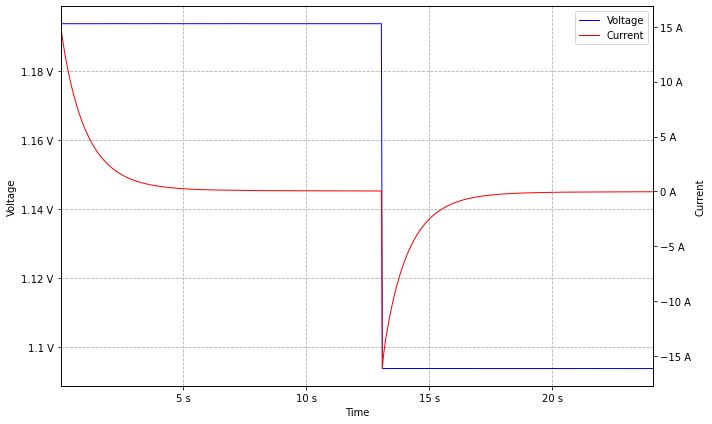

In [19]:
    dataReceiver = ZahnerPP2x2.getDataReceiver()
    dataManager = DataManager(dataReceiver)
    dataManager.plotTIUData()

## Reset configurations

Now the specific example configurations are reset to the default configuration, which are not needed for the next example.

In [20]:
    ZahnerPP2x2.setToleranceBreakEnabled(False)
    ZahnerPP2x2.setVoltageRelation(RELATION.ZERO)
    ZahnerPP2x2.setVoltageParameterRelation(RELATION.ZERO)
    dataReceiver.deletePoints()
    ZahnerPP2x2.setAutorangingEnabled(True)

'ok\n'

# Polarization - aborted with charge limit

The following example shows how polarizing primitives can be aborted on reaching a chargelimit.

The settings of the global limits of current and voltage remain to protect the supercapacitor.

## Setting up the measurement

Here galvanostatic measurement is performed, which makes it easier to read the charge from the diagram. However, potentiostatic charge verification would also be possible.

Galvanostatic mode automatically selects the correct current range. The previously allowed current ranges are kept here as well.

In [21]:
    ZahnerPP2x2.setCoupling(COUPLING.GALVANOSTATIC)

'ok\n'

## Setting up the charge conditions

The supercapacitor is charged by 100 As and then discharged by 50 As.

In [22]:
    ZahnerPP2x2.setMaximumCharge(100)
    ZahnerPP2x2.setMinimumCharge(-50)
    ZahnerPP2x2.setChargeBreakEnabled(True)

'ok\n'

## Execute the primitives

The maximum time is set to 2 minutes.

Charging to 100 As with 2 A charging current should take 50 seconds. Similarly discharging to -50 As with -2 A discharging currents should take 25 seconds.

In [23]:
    ZahnerPP2x2.setMaximumTimeParameter("2 m")

'ok\n'

Set the current to 2 A and measure the polarization to charge the supercapacitor.

In [24]:
    ZahnerPP2x2.setCurrentParameter(2)
    ZahnerPP2x2.measurePolarization()    

'ok\n'

Set a discharge current of -2 A. The charging and discharging parameters can be customized individually.

In [25]:
    ZahnerPP2x2.setCurrentParameter(-2)
    ZahnerPP2x2.measurePolarization()

'ok\n'

## Plot the data

The dataManager measured data can be easily plotted.

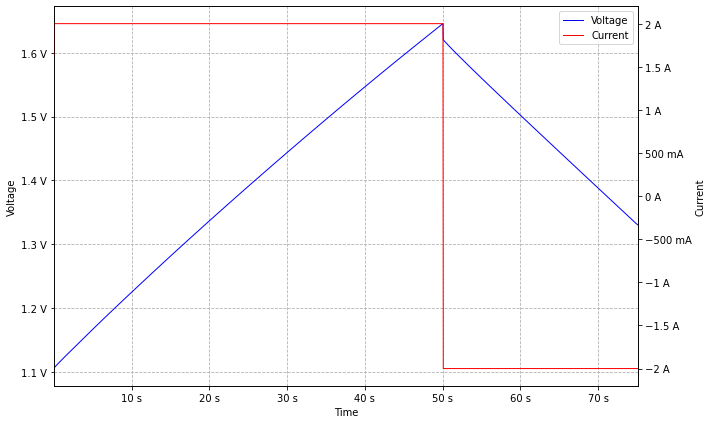

In [26]:
    dataManager.plotTIUData()

The voltage jump at 50 s (observed at the current polarity change) is due to the internal resistance of the supercapacitor, which is about 4 mΩ.

## Reset configurations

Again the configurations are reset to the default configuration, which are not needed for the next example.

In [27]:
    ZahnerPP2x2.setChargeBreakEnabled(False)
    dataReceiver.deletePoints()

# Charging and discharging routines

The following example shows how to charge and discharge a supercapacitor with the polarization primitive.

The settings of the global limits of current and voltage remain to protect the supercapacitor.

## Setting the measurement

The supercapacitor is galvanostatically charged.

In [28]:
    ZahnerPP2x2.setCoupling(COUPLING.GALVANOSTATIC)

'ok\n'

## Setting the reversal potentials

The supercapactor is cycled between 1 V and 2 V.  
To realize this, the functional voltage drop is set to 1 V and 2 V for the polarization primitive.

Here, at the beginning of the primitive the minimum and maximum values must also be observed.  

Depending on test object, the minimum voltage may have to be changed before the first polarization. In the case of supercapacitor, it is assumed that the supercapacitor is completely uncharged therefore a minumum voltage of 1 V is set. The time for which the limit may be exceeded is set to 0.05 seconds to prevent tansients from aborting the measurement.

Functional current aborts for potentiostatic primitives also exist.

In [29]:
    ZahnerPP2x2.setMinimumVoltageParameter(1)
    ZahnerPP2x2.setMaximumVoltageParameter(2)
    ZahnerPP2x2.setParameterLimitCheckToleranceTime(0.05)
    ZahnerPP2x2.setMinMaxVoltageParameterCheckEnabled(True)

'ok\n'

Charging the super capacitor with 10 A current will charge the capacitor to 2 V in 20 seconds hence the maximum charging time is set to 30 seconds.

For safety, a maximum time must always be specified with this primitive can be switched off.

In [30]:
    ZahnerPP2x2.setMaximumTimeParameter("30 s")

'ok\n'

## Execute the primitives

In [31]:
    ZahnerPP2x2.setCurrentParameter(10)
    ZahnerPP2x2.measurePolarization()

'ok\n'

After charging the possibly empty electrolytic capacitor, now the lower voltage limit can be adjusted.

In [32]:
    ZahnerPP2x2.setMinimumVoltageParameter(1)

'ok\n'

Afterwards, two cycles of charging nad discharging are carried out.

In [33]:
    cycles = 2
    for i in range(cycles):
        ZahnerPP2x2.setCurrentParameter(-10)
        ZahnerPP2x2.measurePolarization()
        ZahnerPP2x2.setCurrentParameter(10)
        ZahnerPP2x2.measurePolarization()

At the end, the supercapcitor will have a voltage of 1 V.

In [34]:
    ZahnerPP2x2.setCurrentParameter(-10)
    ZahnerPP2x2.measurePolarization()

'ok\n'

Instead of manually composing the charge or discharge with primitives, user may also use the charge [measureCharge()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureCharge) and discharge [measureDischarge()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureDischarge) methods, which have been programmed as an example of how primitives can be composed into more complex methods.

## Plot the data

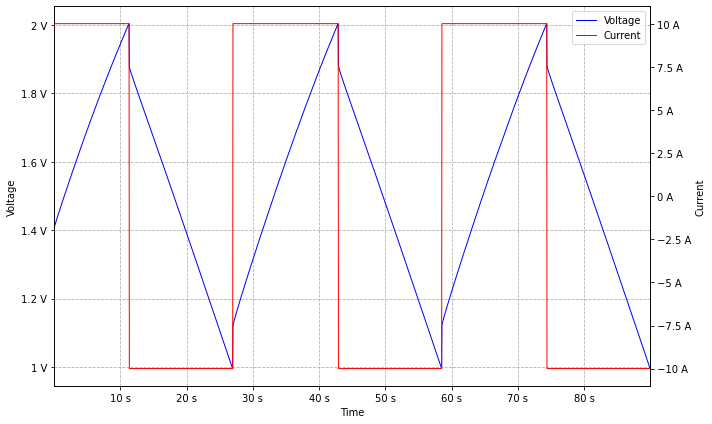

In [35]:
    dataManager.plotTIUData()

## Reset configurations

Now the specific example configurations are reset to the default configuration, which are not needed for the next example.

In [36]:
    ZahnerPP2x2.setMinMaxVoltageParameterCheckEnabled(False)
    dataReceiver.deletePoints()

# Open circuit voltage scan

The following example shows how to record the open circuit voltage scan.

In principle, the open circuit voltage scan [measureOCVScan()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureOCVScan) is same as a galvanostatic polarization with the potentiostat turned off.  
The user may set a minimum and maximum voltage at which the primitive can be stopped.  
Also a voltage change tolerance as shown in a previous example is possible. For example, to measure OCV until the voltage change has diminshed and the OCV is stable.

The settings of the global limits of current and voltage remain to protect the supercapacitor.

## Setting the measurement

Only the maximum time is configured. A change in tolerance or a range limit has already been shown in the previous examples.

5 minutes measurement time is set.

And the sampling rate is reduced to 1 Hz because there is less dynamic change in the measurement.

In [37]:
    ZahnerPP2x2.setMaximumTimeParameter("2 min")
    ZahnerPP2x2.setSamplingFrequency(1)

'ok\n'

## Execute the primitive

The primitve can simply be started, nothing else needs to be configured.

In [38]:
    ZahnerPP2x2.measureOCVScan()

'ok\n'

## Plot the data

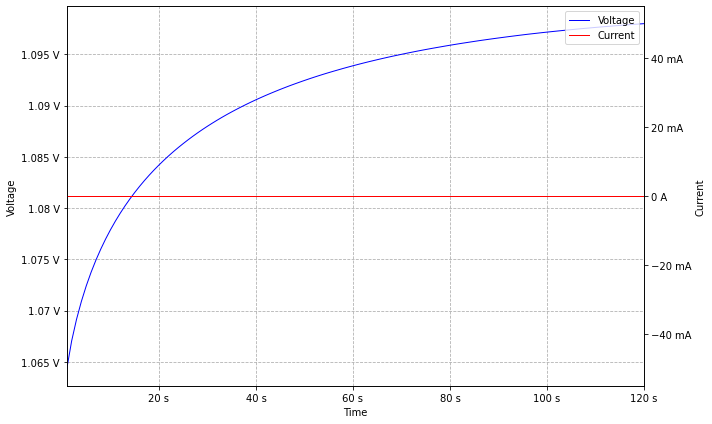

In [39]:
    dataManager.plotTIUData()

# Close the connection

Closing the online display when it has been opened and close the connection to the device.

In [40]:
    if onlineDisplay != None:
        onlineDisplay.close()
    
    ZahnerPP2x2.close()
    print("finish")

finish
